In [1]:
import torch
import os
import pickle
from tqdm import tqdm
from pylab import rcParams
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



In [2]:
# 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic, Linux: 나눔고딕 등)
plt.rcParams['font.family'] = 'AppleGothic'  # Windows

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv(r'/Users/eunseo/Downloads/projects/api/data/datasets/pre_df.csv')
df.head()

,datetime,month,day,weekday,hour_decimal,교차로명,latitude,longitude,vehicle_버스,vehicle_대형,...,dir_4,dir_5,dir_6,dir_7,dir_8,dir_9,dir_10,dir_11,dir_12,traffic_volume
0,2023-03-15 07:30:00,3,15,2,7.5,공촌3교4거리,37.536019,126.631909,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2023-03-15 07:30:00,3,15,2,7.5,송도4교4거리,37.387170,126.684001,0,1,...,0,0,0,0,0,0,0,0,0,2
2,2023-03-15 07:30:00,3,15,2,7.5,송도4교4거리,37.387170,126.684001,0,0,...,0,0,0,0,0,0,0,0,0,7
3,2023-03-15 07:30:00,3,15,2,7.5,송도3교4거리,37.408634,126.646415,0,0,...,0,0,0,0,0,0,1,0,0,56
4,2023-03-15 07:30:00,3,15,2,7.5,송도3교4거리,37.408634,126.646415,0,1,...,0,0,0,0,0,0,1,0,0,0


In [4]:
df = df.drop(columns=['weekday'])
train_df = df[df['month'].isin([3,5,9])]
test_df = df[df['month'] == 11]

df_train = train_df.copy()
df_test = test_df.copy()

In [5]:
# 입력값만 스케일링
input_features = ['month', 'day', 'hour_decimal', 'latitude', 'longitude']

scaler_X = StandardScaler()

# 훈련 데이터와 테스트 데이터 입력값 스케일링
df_train[input_features] = scaler_X.fit_transform(df_train[input_features])
df_test[input_features] = scaler_X.transform(df_test[input_features])

# 타겟값 스케일링
scaler_y = StandardScaler()

# 타겟값 스케일링
df_train['traffic_volume'] = scaler_y.fit_transform(df_train[['traffic_volume']])
df_test['traffic_volume'] = scaler_y.transform(df_test[['traffic_volume']])

In [6]:
train_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
train_target = ['traffic_volume']

test_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
test_target = ['traffic_volume']

In [43]:
# 입력값 스케일러 저장
with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# 타겟값 스케일러 저장
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

In [7]:
def create_sequences_by_intersection(df, seq_length, features, target):
    sequences = []
    targets = []
    
    # 교차로별로 그룹화
    grouped_intersections = df.groupby('교차로명')
    
    for intersection, group in grouped_intersections:
        # 시간대별로 그룹화
        grouped = group.groupby('datetime')
        time_groups = sorted(grouped.groups.keys())
        
        for i in range(len(time_groups) - seq_length + 1):
            sequence = []
            for j in range(seq_length):
                current_time = time_groups[i + j]
                current_data = grouped.get_group(current_time)[features].values
                mean_data = np.mean(current_data, axis=0)
                sequence.append(mean_data)
            
            target_time = time_groups[i + seq_length - 1]
            target_data = grouped.get_group(target_time)[target].values
            target_mean = np.mean(target_data)
            
            sequences.append(sequence)
            targets.append(target_mean)
    
    return np.array(sequences), np.array(targets)


In [8]:
# 훈련 데이터를 훈련셋과 검증셋으로 분할
# train_size = int(len(df_train) * 0.8)  # 80%를 훈련셋으로 사용

# 데이터 분할
train_data = df_train
# train_data = df_train[:train_size]
# val_data = df_train[train_size:]  # 나머지 20%를 검증셋으로 사용
test_data = df_test  # 테스트셋은 별도의 데이터 사용

seq_length = 4

# 시퀀스 생성
X_train, y_train = create_sequences_by_intersection(train_data, seq_length, train_features, train_target)
# X_val, y_val = create_sequences_by_intersection(val_data, seq_length, train_features, train_target)
X_test, y_test = create_sequences_by_intersection(test_data, seq_length, test_features, test_target)

In [9]:
print(X_train.shape)
# print(X_val.shape)
print(X_test.shape)

(690, 4, 19)
(210, 4, 19)


In [10]:
def make_Tensor(array):
    return torch.from_numpy(array).float()

In [11]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
# X_val = make_Tensor(X_val)
# y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [12]:
class CNNLSTM_Model(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CNNLSTM_Model, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(
            in_channels=n_features,
            out_channels= 19,
            kernel_size = 2,
            stride = 1
        )

        self.c2 = nn.Conv1d(
            in_channels=19,
            out_channels= 38,
            kernel_size = 2,
            stride = 1
        )

        self.c3 = nn.Conv1d(
            in_channels=38,
            out_channels= 76,
            kernel_size = 2,
            stride = 1
        )

        self.bn = nn.BatchNorm1d(20) 

        self.lstm = nn.LSTM(
            input_size= 76,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=0.1)
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self, batch_size):
        self.hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden),
            torch.zeros(self.n_layers, batch_size, self.n_hidden)
        )

    def forward(self, sequences):
        sequences = sequences.permute(0, 2, 1)
        conv_out = self.c1(sequences)
        conv_out = torch.relu(conv_out)  # 활성화 함수
        conv_out = self.c2(conv_out)  # 두 번째 Conv1D
        conv_out = torch.relu(conv_out)  # 활성화 함수
        conv_out = self.c3(conv_out)  # 두 번째 Conv1D
        conv_out = torch.relu(conv_out)  # 활성화 함수

        conv_out = conv_out.permute(0, 2, 1)  # Conv1D 결과에서 channel dimension 제거

        # LSTM에 데이터 전달
        lstm_out, _ = self.lstm(conv_out)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]  # 마지막 time step 추출
        
        y_pred = self.linear(last_time_step)
        return y_pred

In [13]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_hist = []
    val_hist = []

    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함

            batch_size = seq.size(0) if seq.ndim > 1 else 1
            model.reset_hidden_state(batch_size)

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred.float(), train_labels[idx].unsqueeze(0).unsqueeze(1).float())

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:
            with torch.no_grad():
                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):
                    batch_size = val_seq.size(0) if val_seq.ndim > 1 else 1
                    model.reset_hidden_state(batch_size) #seq 별로 hidden state 초기화

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred.float(), val_labels[val_idx].unsqueeze(0).unsqueeze(1).float())
                    val_loss += val_step_loss.item()

            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            # Early stopping
            if len(val_hist) > patience and val_hist[-1] > min(val_hist[-patience:]):
                print('\nEarly Stopping')
                break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


    return model, train_hist, val_hist

In [14]:
model = CNNLSTM_Model(
    n_features=19,
    n_hidden=32, # 은닉 노드
    seq_len=4, # 시퀀스 길이
    n_layers=1 # 레이어의 수
)

In [15]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    # X_val,
    # y_val,
    num_epochs=500,
    verbose=10, # 출력 단위
    patience=500 #조기 종료
)

Epoch 0 train loss: 0.13537629801995943
Epoch 10 train loss: 0.0830045177915093
Epoch 20 train loss: 0.07843988468175403
Epoch 30 train loss: 0.07239824348176573
Epoch 40 train loss: 0.06193537057843059
Epoch 50 train loss: 0.05370659734243932
Epoch 60 train loss: 0.0517508409883611
Epoch 70 train loss: 0.04712745603578894
Epoch 80 train loss: 0.046168188517913225
Epoch 90 train loss: 0.045871685534054275
Epoch 100 train loss: 0.040990275362560495
Epoch 110 train loss: 0.044169925631739305
Epoch 120 train loss: 0.039261105436615755
Epoch 130 train loss: 0.03989759650371591
Epoch 140 train loss: 0.034274846624475025
Epoch 150 train loss: 0.036503048320773286
Epoch 160 train loss: 0.035719901270341074
Epoch 170 train loss: 0.03726171587722079
Epoch 180 train loss: 0.033892143496136735
Epoch 190 train loss: 0.03744572923430984
Epoch 200 train loss: 0.03309670035977025
Epoch 210 train loss: 0.030784792007972905
Epoch 220 train loss: 0.03310894889628812
Epoch 230 train loss: 0.0322608719320

In [24]:
PATH = "0108cnn3model.pth"  # 현재 디렉토리에 저장

In [25]:
torch.save(model.state_dict(), PATH)

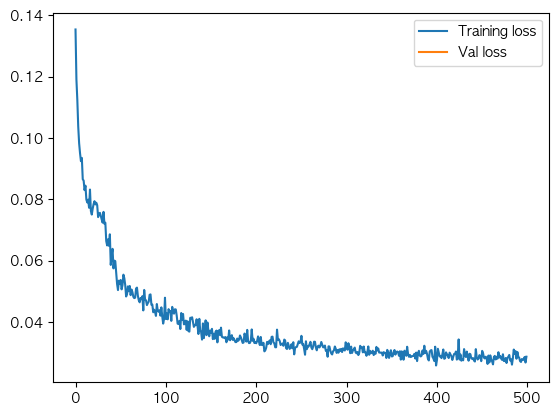

In [16]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [17]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state(batch_size=1)
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [18]:
# preds를 numpy array로 변환 (1D -> 2D)
preds = np.array(preds).reshape(-1, 1)

# 예측값 역스케일링
y_pred_original = scaler_y.inverse_transform(preds)

# 실제값 역스케일링
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


In [19]:
# 매핑을 위해 학습에 사용된 데이터프레임과 동일한 데이터 필요
df_test['datetime'] = pd.to_datetime(df_test['datetime'])  # datetime 형식 변환
df_test = df_test.sort_values(by=['교차로명', 'datetime'])  # 교차로명과 시간으로 정렬

# 예측에 사용된 교차로별 데이터의 인덱스 추출
mapping_info = df_test[['datetime', '교차로명']].iloc[seq_length:].reset_index(drop=True)

mapping_info = mapping_info.drop_duplicates(subset=['datetime', '교차로명']).reset_index(drop=True)

unique_intersections = mapping_info['교차로명'].unique()

# 교차로의 개수
num_intersections = len(unique_intersections)

# 각 교차로에 할당할 데이터 개수
rows_per_intersection = len(y_test_original) // int(num_intersections)

In [20]:
# 결과를 저장할 리스트
results = []

# 교차로별 데이터 처리
start_idx = 0
for i, intersection in enumerate(unique_intersections):
    # 마지막 교차로는 나머지를 포함하여 할당
    if i == num_intersections - 1:
        end_idx = len(y_test_original)
    else:
        end_idx = start_idx + rows_per_intersection
    
    # 교차로별 예측값과 실제값 슬라이싱
    y_pred_intersection = y_pred_original[start_idx:end_idx]
    y_test_intersection = y_test_original[start_idx:end_idx]
    
    # 데이터가 비어 있는지 확인
    if len(y_pred_intersection) == 0 or len(y_test_intersection) == 0:
        print(f"Error: No data for {intersection}")
        continue

    # 다음 교차로로 이동
    start_idx = end_idx
    
    # 결과 저장 (딕셔너리 형태로)
    results.append({
        'intersection': intersection,
        'predicted': y_pred_intersection.flatten().tolist(),
        'actual': y_test_intersection.flatten().tolist()
    })

# 저장된 결과 확인
for result in results:
    print(f"{result['intersection']}:")
    print("Predicted:", result['predicted'])
    print("Actual:", result['actual'])


공촌3교4거리:
Predicted: [22.20095871845644, 21.60900136414939, 17.400925976868873, 14.104584544786281, 10.943168241967225, 7.433232442662913, 8.495883984471448, 6.821145250808083, 6.24034382518067, 7.086653271115974, 10.457165334248232, 7.974247058125499, 7.591850435450652, 17.948928318136048, 18.61943725799801, 20.961669571845846, 20.932528236802682, 20.158762210243665, 19.554668991744737, 17.33869950801214, 14.49428914836983]
Actual: [22.916666666976905, 22.222222229001886, 15.888888864456996, 13.916666968834681, 11.722222612493146, 7.9444437873565725, 7.9444437873565725, 9.083332582940626, 10.499999830309976, 8.111111760554806, 9.888888439218393, 8.333332717728936, 9.777777960631326, 19.388888861922, 18.1666664556251, 22.61111115937425, 23.277777789759366, 18.027777981504997, 15.833333625163462, 14.027777447421746, 11.750000608026186]
봉수교3거리:
Predicted: [19.171135313095775, 17.69438490039512, 15.874319512537367, 14.278727392398181, 14.443833182248168, 15.530925601263052, 13.914846175731

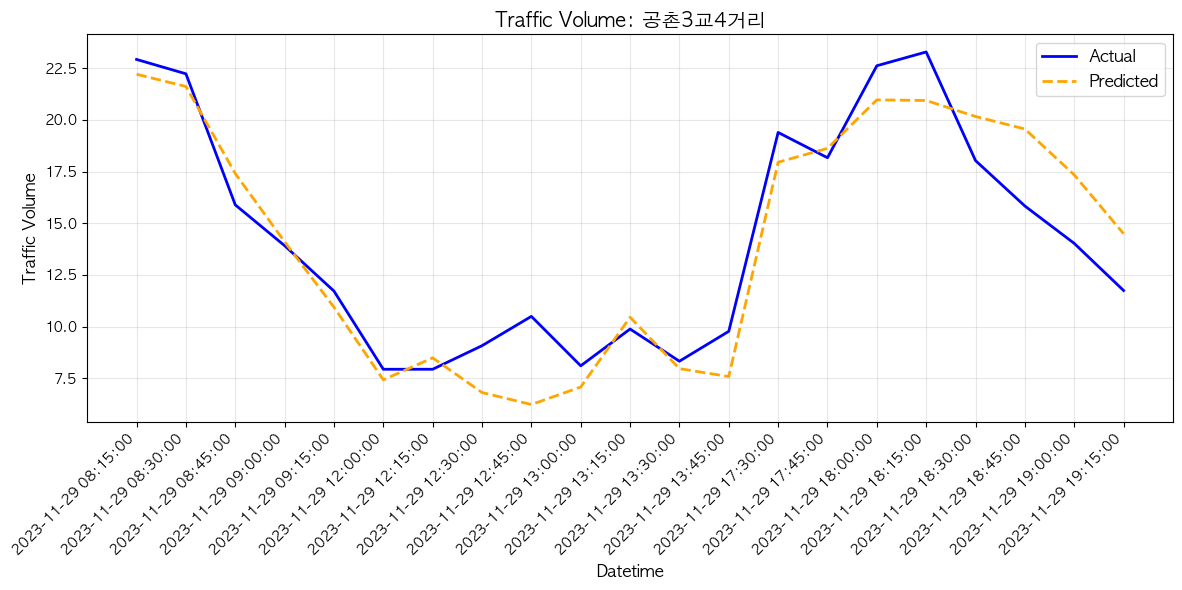

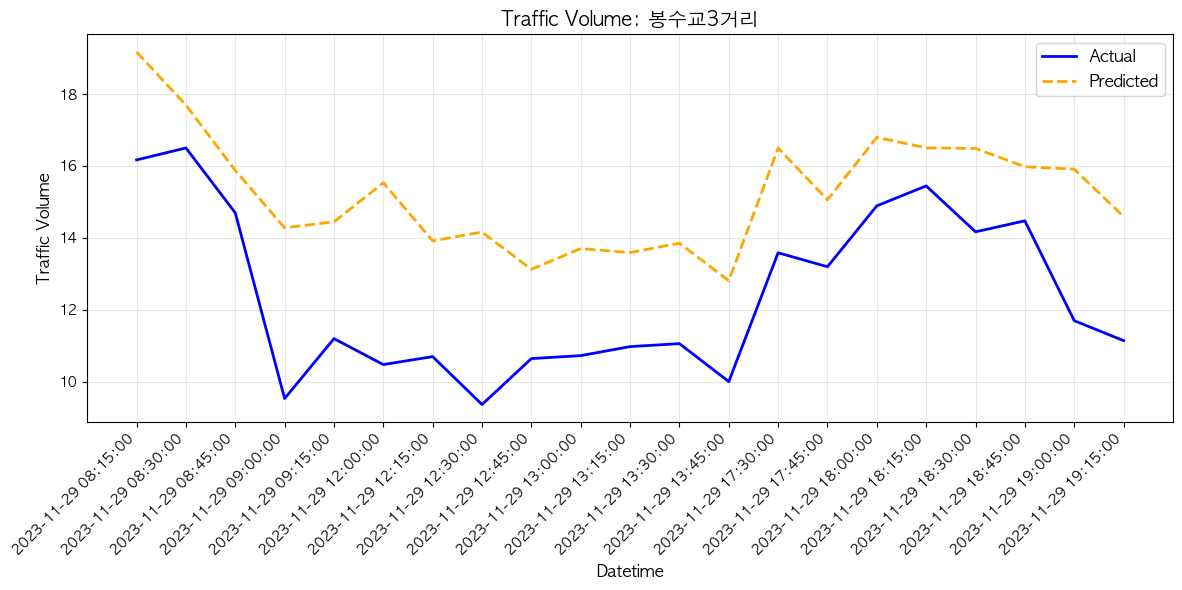

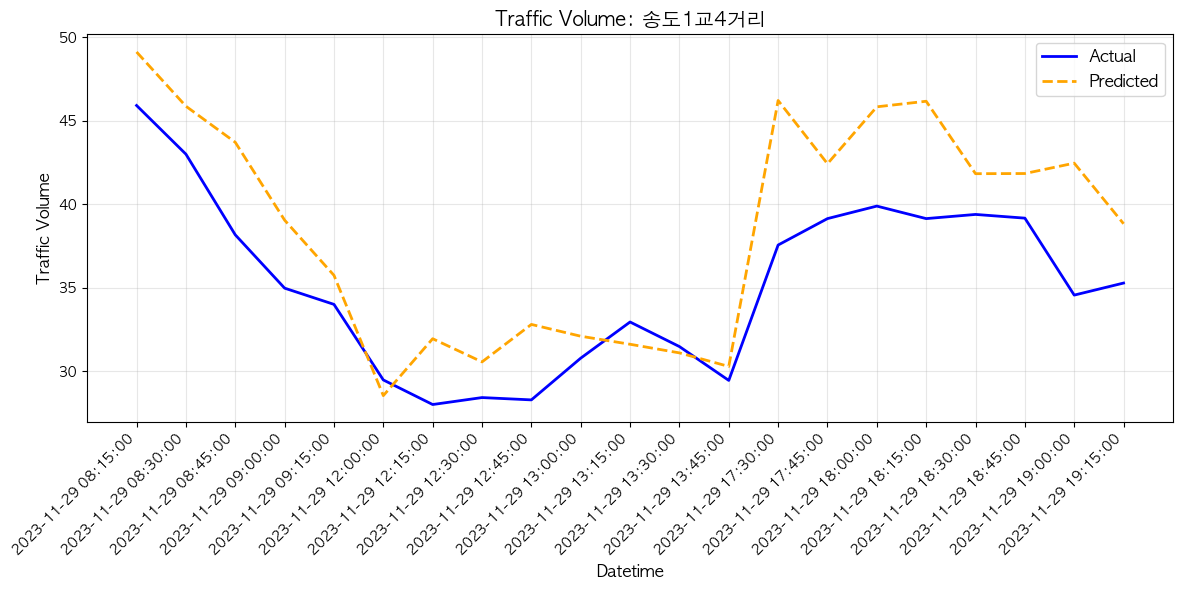

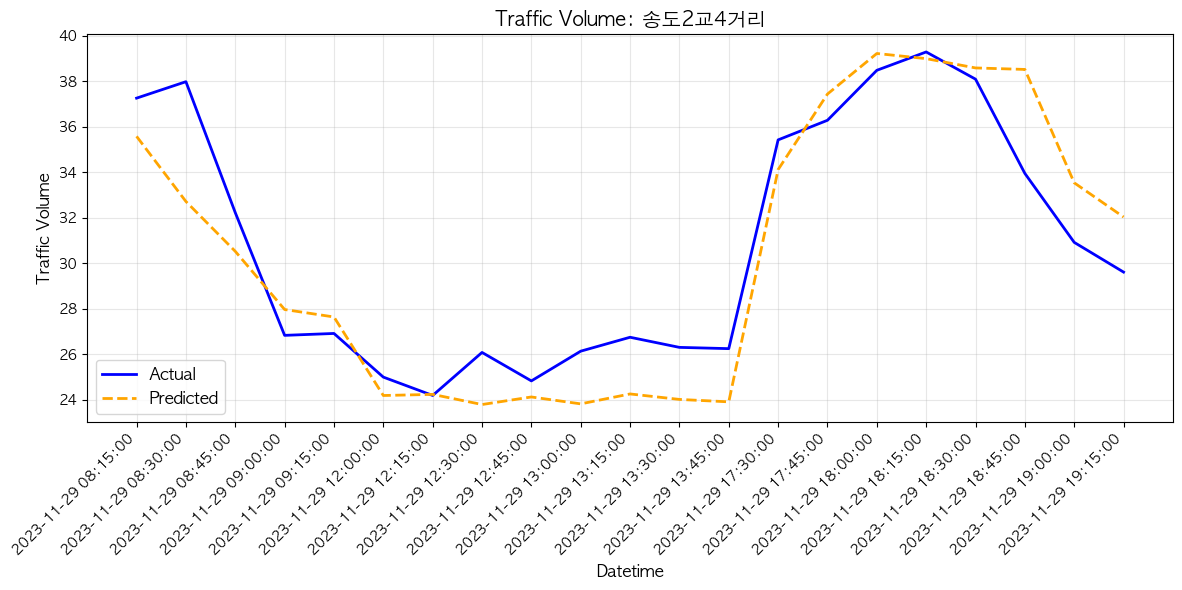

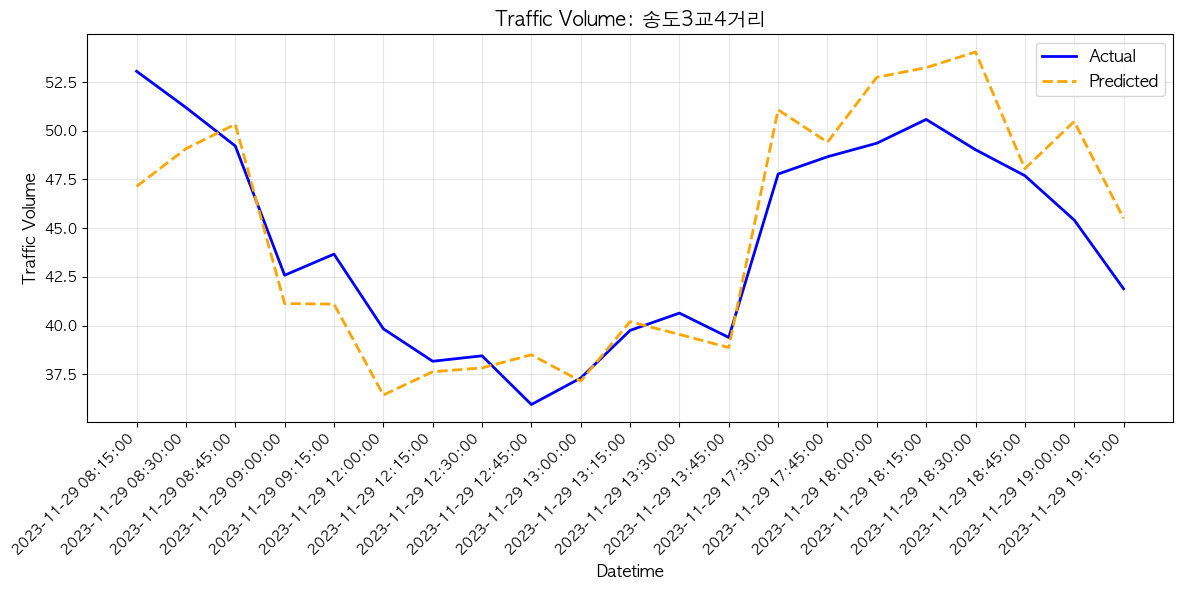

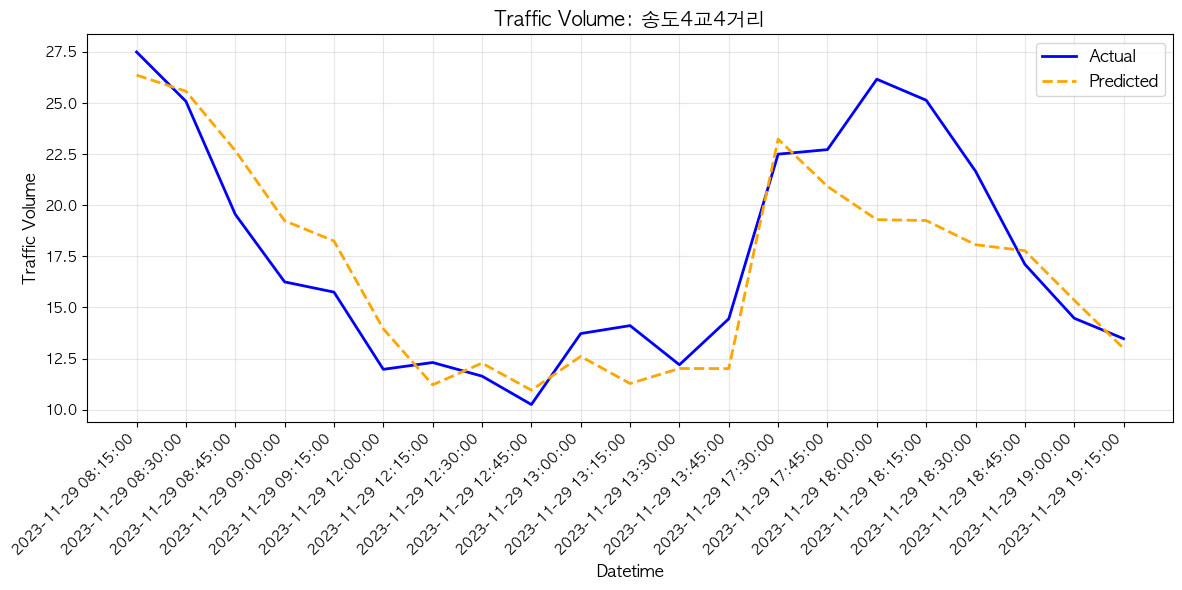

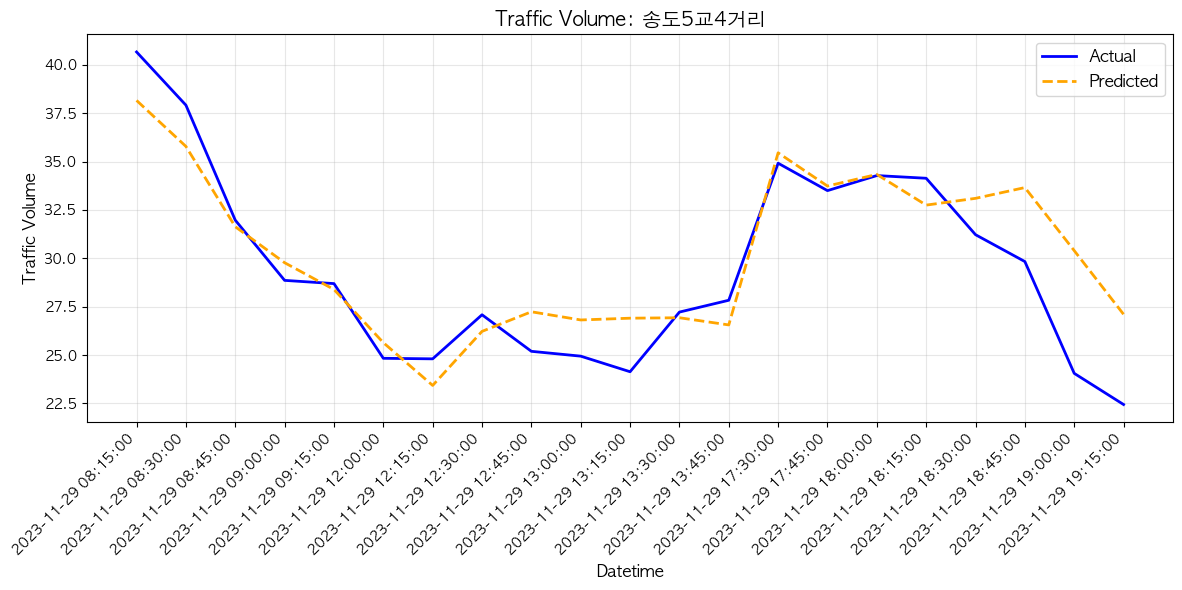

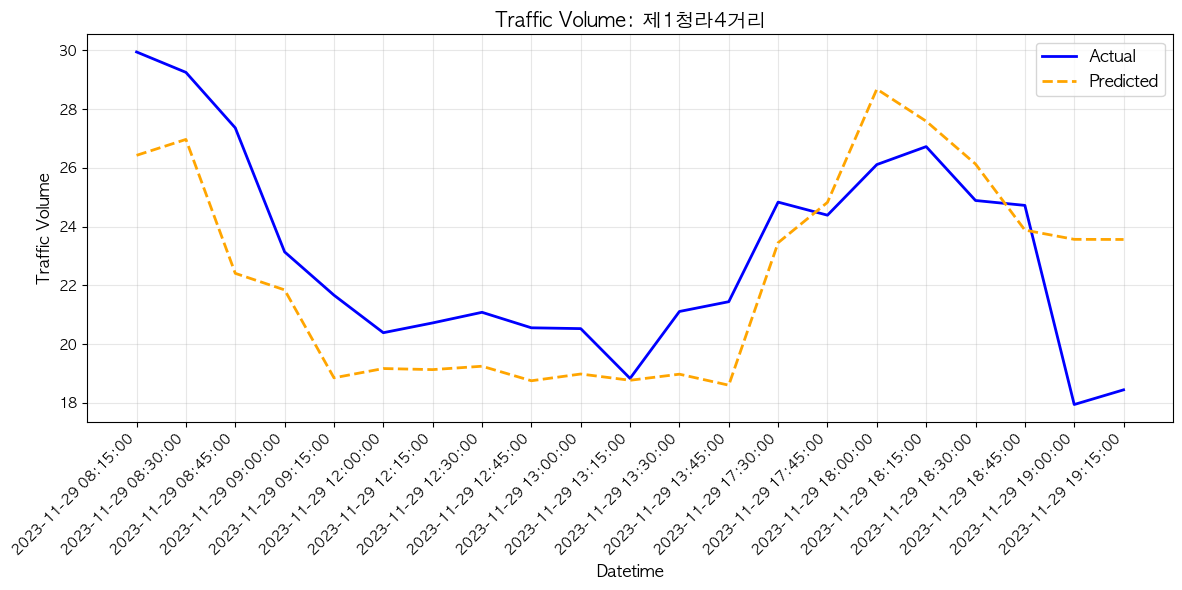

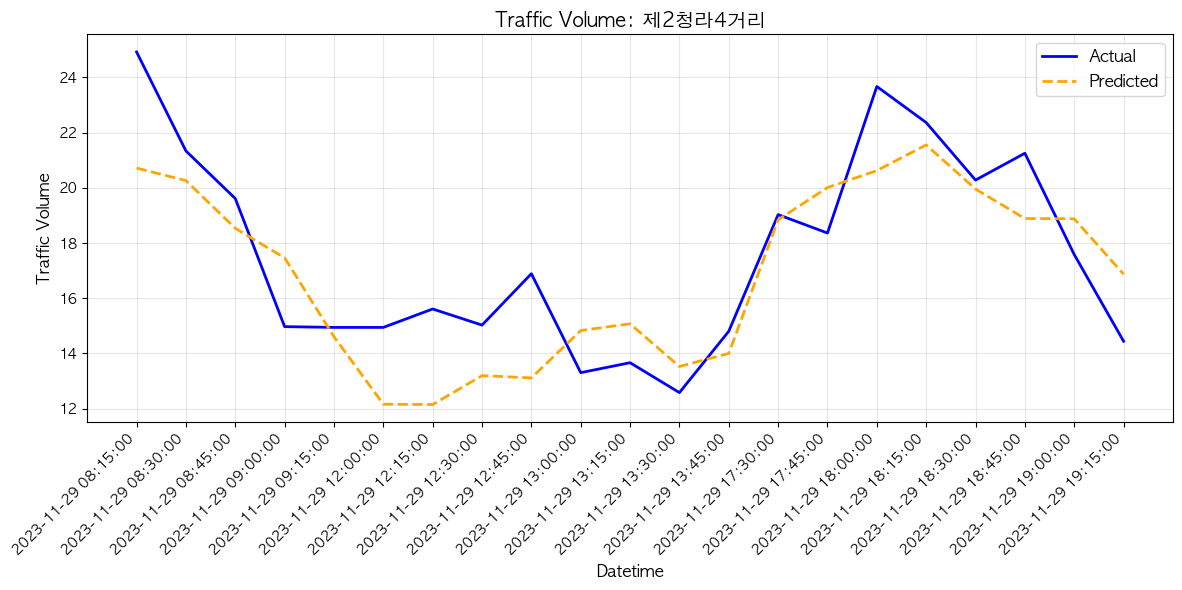

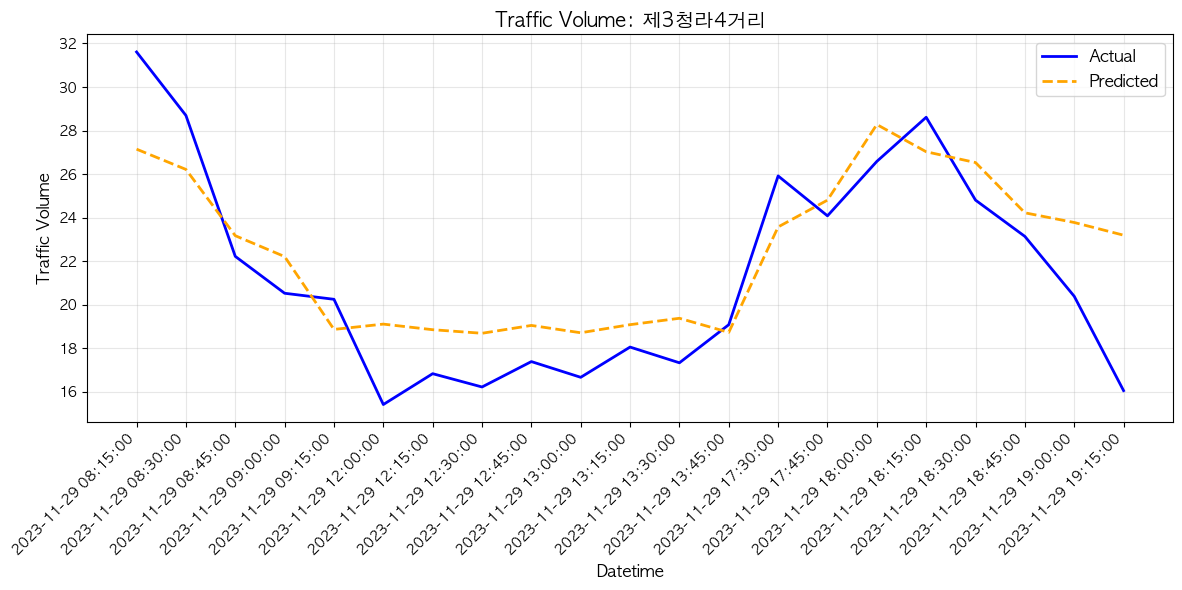

In [21]:
# 교차로별 시각화
for result in results:
    intersection = result['intersection']
    predicted = result['predicted']
    actual = result['actual']

     # 교차로별 datetime 데이터 슬라이싱
    intersection_data = mapping_info[mapping_info['교차로명'] == intersection]
    datetime_labels = intersection_data['datetime'].iloc[-rows_per_intersection:]  # 뒤에서부터 rows_per_intersection 개수 가져오기


    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual)), actual, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(predicted)), predicted, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"Traffic Volume: {intersection}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.xticks(range(len(datetime_labels)), datetime_labels, rotation=45, ha='right')  # x축에 datetime 레이블 추가
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# 교차로별 시각화
for result in results:
    intersection = result['intersection']
    predicted = np.array(result['predicted'])  # 리스트를 numpy 배열로 변환
    actual = np.array(result['actual'])        # 리스트를 numpy 배열로 변환

    # 차이 기준 (20%)
    threshold = 0.2  # 20% 차이 기준

    # 상대 오차 계산
    relative_error = abs(actual - predicted) / actual

    # 강조 표시를 위한 조건 생성
    significant_anomalies = relative_error > threshold

    # 교차로별 datetime 데이터 슬라이싱
    intersection_data = mapping_info[mapping_info['교차로명'] == intersection]
    datetime_labels = intersection_data['datetime'].iloc[-rows_per_intersection:]  # 뒤에서부터 rows_per_intersection 개수 가져오기

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual)), actual, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(predicted)), predicted, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.fill_between(
        range(len(actual)),  # x축 인덱스
        actual,
        predicted,
        where=significant_anomalies,  # 차이가 일정값 초과 시 강조
        color='red',
        alpha=0.3,
        label='Significant Deviation'
    )
    plt.title(f"Traffic Volume: {intersection}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.xticks(range(len(datetime_labels)), datetime_labels, rotation=45, ha='right')  # x축에 datetime 레이블 추가
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [22]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

# RMSE 함수
def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# MAPE 함수
def MAPE(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

In [23]:
print("MAE:", MAE((np.array(y_test_original)), (np.array(y_pred_original))))
print("RMSE:", RMSE((np.array(y_test_original)), (np.array(y_pred_original))))
print("MAPE:", MAPE((np.array(y_test_original)), (np.array(y_pred_original))))

MAE: 2.1871525053448506
RMSE: 2.7306287041426076
MAPE: 10.631781359773855
